# Regularized Regression Project

Build a Ridge, Lasso, and ElasticNet models that predict the `price` column in the dataset on San Francisco Apartment rentals. Make sure to go through all the the relevant steps of the modelling workflow.

1. Does regularization improve fit?
2. Perform EDA
3. Engineer Features as needed
4. Fit a Lasso, Ridge, and Elastic Net Regression using the features in your original model.
5. Once you are ready, fit your final model and report final model performance estimate by scoring on the test data. Report both test R-squared and MAE.

Advice:

1. Remember, regularization doesn't always help, but it can, especially if you let it choose features for you!

In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mse
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2

In [2]:
apartments = pd.read_csv("/Users/huzaifamalik/Downloads/Python for Data Science/Regression/Course Materials/Data/sf_clean.csv")

In [3]:
apartments.shape

(989, 9)

In [4]:
apartments.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


## Exploratory Data Analysis (EDA)

In [7]:
# First check if there are any missing values

apartments.loc[apartments.isna().any(axis = 1)]

#No missing values as per below

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district


In [10]:
#Second, check for duplicates
#Multiple rows are duplicates but we can keep them since different apartments can have exact sane features

apartments.loc[apartments.duplicated()].shape

(28, 9)

In [11]:
# Thirdly, check categorical data columns for any inconsistent text and typos

for col in apartments.select_dtypes("object").columns:
    print(apartments[col].value_counts(dropna=False))
    print("\n")

laundry
(a) in-unit       488
(b) on-site       370
(c) no laundry    131
Name: count, dtype: int64


pets
(d) no pets    510
(a) both       367
(c) cats        91
(b) dogs        21
Name: count, dtype: int64


housing_type
(c) multi     937
(a) single     40
(b) double     12
Name: count, dtype: int64


parking
(d) no parking    478
(b) protected     439
(c) off-street     38
(a) valet          34
Name: count, dtype: int64




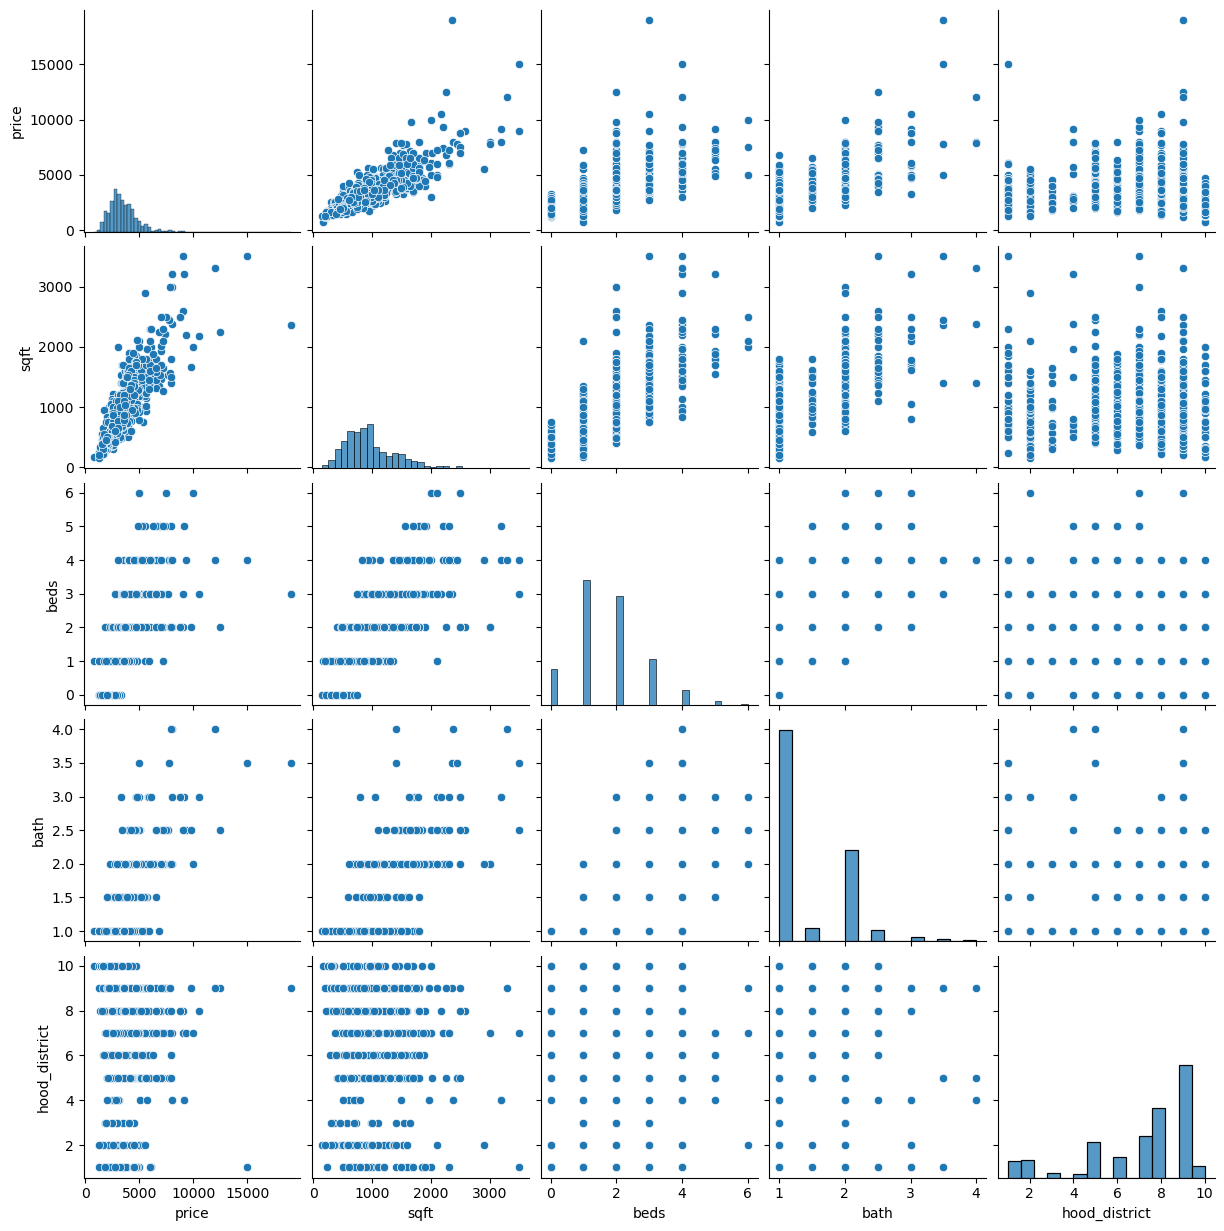

In [13]:
# Fourth, check for outliers in price and sqft using pairplot, histplots and +-3 standard deviations formula
sns.pairplot(apartments);

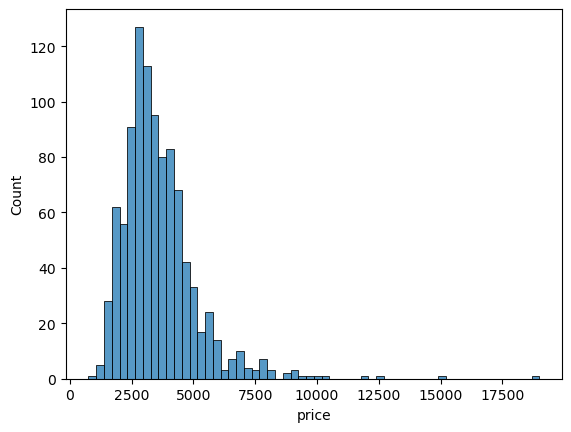

In [17]:
sns.histplot(apartments["price"]);

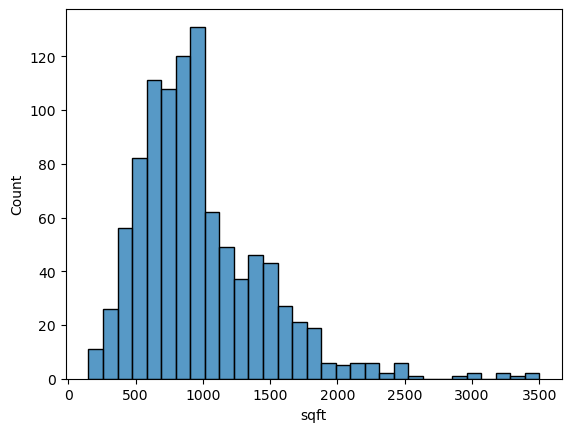

In [18]:
sns.histplot(apartments["sqft"]);

In [23]:
mean_price = np.mean(apartments["price"])
mean_sd = np.std(apartments["price"])

print(f"Mean Price: {mean_price}")
print(f"Std Price: {mean_sd}")
print("\n")

print(mean_price - (3 * mean_sd))
print(mean_price + (3 * mean_sd))

Mean Price: 3595.035389282103
Std Price: 1545.4407625062643


-1041.28689823669
8231.357676800897


In [25]:
#Apartments below have a price of more than 3 standard deviations from the mean price. Highest price being 19,000
#Thus, there are technically outliers but we will keep them when using different regression techniques

apartments.loc[apartments["price"] > (mean_price + (3 * mean_sd))]

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
11,15000,3500.0,4.0,3.5,(a) in-unit,(d) no pets,(a) single,(b) protected,1.0
192,9300,2200.0,4.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
206,10000,2000.0,6.0,2.0,(a) in-unit,(d) no pets,(a) single,(c) off-street,7.0
253,19000,2358.0,3.0,3.5,(a) in-unit,(d) no pets,(c) multi,(a) valet,9.0
409,9100,3200.0,5.0,3.0,(a) in-unit,(d) no pets,(a) single,(d) no parking,4.0
410,9000,2588.0,2.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,8.0
589,8750,2490.0,2.0,3.0,(a) in-unit,(a) both,(c) multi,(a) valet,8.0
590,8750,2490.0,2.0,3.0,(a) in-unit,(a) both,(c) multi,(a) valet,8.0
602,12500,2250.0,2.0,2.5,(a) in-unit,(a) both,(c) multi,(a) valet,9.0


In [36]:
#Classify the hood district numbers into regions (North, South, East, West and Central) and add it to dataframe

regions = []
for district in apartments["hood_district"]:
    
    if (district == 1.0) | (district == 2.0):
        regions.append("West")
        
    elif (district == 8.0) | (district == 9.0):
        regions.append("East")
    
    elif (district == 4.0) | (district == 5.0) | (district == 6.0):
        regions.append("Central")
        
    elif (district == 3.0) | (district == 10.0):
        regions.append("South")
    
    elif district == 7.0:
        regions.append("North")
    
    else:
        regions.append("N/A")

In [38]:
apartments["region"] = regions

In [39]:
apartments.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district,region
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0,North
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0,North
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0,North
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0,North
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0,North


## Linear Regression

In [116]:
features = ["sqft", "bath", "beds", "parking_or_not", "region", "bath_sq"]

apartments_copy = apartments.assign(
    laundry_or_not = np.where(
        apartments["laundry"].str.contains("no", case = False, regex = True), 0, 1
    ),
    pets_or_not = np.where(
        apartments["pets"].str.contains("no", case = False, regex = True), 0, 1
    ),
    parking_or_not = np.where(
        apartments["parking"].str.contains("no", case = False, regex = True), 0, 1
    ),
    sqft_sq = apartments["sqft"] ** 2,
    bath_sq = apartments["bath"] ** 2,
    beds_sq = apartments["beds"] ** 2
)

X = sm.add_constant(pd.get_dummies(apartments_copy.loc[:, features], drop_first= True).astype("float"))
y = apartments_copy["price"]

model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     340.5
Date:                Wed, 22 Oct 2025   Prob (F-statistic):          2.55e-294
Time:                        14:49:31   Log-Likelihood:                -7964.2
No. Observations:                 989   AIC:                         1.595e+04
Df Residuals:                     979   BIC:                         1.600e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1988.0201    176.979     11.233      0.000    1640.719    2335.321
sqft               1.9512      0.093     20.894      0.000       1.768       2.134
bath           -1236.6588    221.305     -5.588      0.000   -1670.946    -802.371
beds             173.5604     37.437      4.636      0.000     100.094     247.027
parking_or_not   256.5388     51.096      5.021      0.000     156.268     356.810
bath_sq          483.3505     60.204      8.028      0.000     365.206     601.495
region_East      -37.5132     67.334     -0.557      0.578    -169.648      94.622
region_North     141.9732     90.250      1.573      0.116     -35.133     319.079
region_South    -871.4184    125.702     -6.932      0.000   -1118.095    -624.741
region_West     -455.6146     95.326     -4.780      0.000    -642.682    -268.547
==============================================================================
Omnibus:                      821.896   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54775.108
Skew:                           3.319   Prob(JB):                         0.00
Kurtosis:                      38.849   Cond. No.                     1.26e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

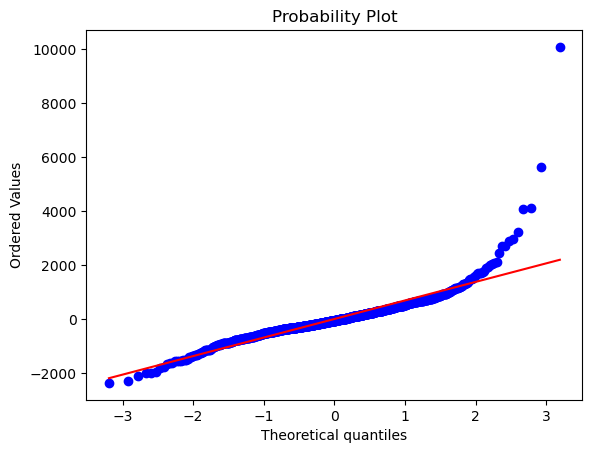

In [102]:
# See Normality of Residues or Errors
stats.probplot(model.resid, dist = "norm", plot = plt);

In [103]:
#Check VIF values to see any multi collinearity
vif_values_list = []
for i in range(X.shape[1]):
    vif_values_list.append(vif(X.values, i))

pd.DataFrame(
    {
        "Column_Name": X.columns,
        "VIF": vif_values_list
    }
)

,Column_Name,VIF
0,const,58.281280
1,sqft,3.322759
2,bath,26.229582
3,beds,2.748127
4,parking_or_not,1.103847
5,bath_sq,24.753908
6,region_East,1.903468
7,region_North,1.501752
8,region_South,1.210919
9,region_West,1.410715


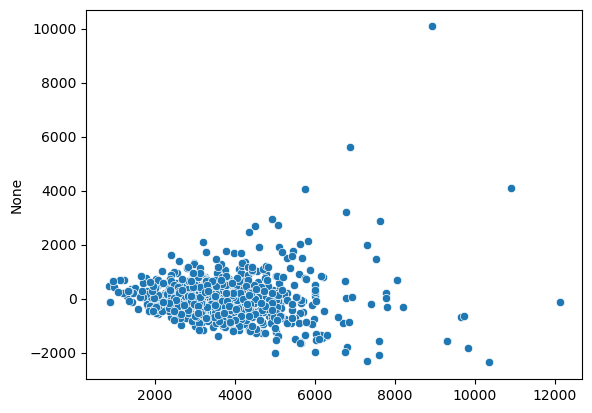

In [104]:
#Check Residue Plot to see the variance in errors
sns.scatterplot(x = model.predict(), y = model.resid);

In [106]:
#Check Cook's Distance
influence = model.get_influence()
inf_summary_df = influence.summary_frame()
inf_summary_df.head(2)

,dfb_const,dfb_sqft,dfb_bath,dfb_beds,dfb_parking_or_not,dfb_bath_sq,dfb_region_East,dfb_region_North,dfb_region_South,dfb_region_West,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.067494,0.062227,0.067336,-0.071420,-0.029761,-0.059985,-0.011290,0.123723,-0.001053,0.003068,0.004610,1.953825,0.011933,0.214713,1.956645,0.215023
1,0.028654,-0.029235,-0.014736,0.012304,-0.033839,0.015439,-0.003911,0.058663,-0.000498,-0.002247,0.000777,0.816009,0.011540,0.088170,0.815869,0.088155


In [107]:
inf_summary_df["cooks_d"].sort_values(ascending=False).head(3)

253    1.147464
11     0.278421
199    0.210573
Name: cooks_d, dtype: float64

In [109]:
#This is an influencial and legitimate outlier (very expensive apartment)
#Won't remove outlier, use RidgeCV, LassoCV and Elastic Net to make the model less sensitive to its influence 

apartments_copy.iloc[253]

price                   19000
sqft                   2358.0
beds                      3.0
bath                      3.5
laundry           (a) in-unit
pets              (d) no pets
housing_type        (c) multi
parking             (a) valet
hood_district             9.0
region                   East
laundry_or_not          False
pets_or_not              True
parking_or_not          False
sqft_sq             5560164.0
bath_sq                 12.25
beds_sq                   9.0
Name: 253, dtype: object

In [148]:
#Perform Cross Validation of Linear Regression with Training and Testing data

kf = KFold(n_splits = 5, shuffle = True, random_state=2023)

r2_scores_list = []
mae_list = []

for train_index, test_index in kf.split(X,y):
    
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
    train_model = sm.OLS(y_train, X_train).fit()
    
    y_predicted = train_model.predict(X_test)
    
    r2_scores_list.append(r2(y_test, y_predicted))
    mae_list.append(mae(y_test, y_predicted))

print("R2 scores list", r2_scores_list)
print("MAE scores list", mae_list)
print("\n")
print(f"Test Data Avg R2: {np.mean(r2_scores_list)}")
print(f"Test Data Avg MAE: {np.mean(mae_list)}")

R2 scores list [0.816995808195442, 0.7103720313996074, 0.8047071570677683, 0.7757992621811637, 0.649145648510804]
MAE scores list [440.8030378727041, 465.147018294744, 501.6285399510704, 523.5304309148946, 558.091405157646]


Test Data Avg R2: 0.751403981470957
Test Data Avg MAE: 497.8400864382118


## RidgeCV Model

In [149]:
#1 Split into train/test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

#2 Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#3 Define RidgeCv with multiple alphas
n_alphas = 200
alphas = 10 ** np.linspace(-3,3,n_alphas)

ridge_model = RidgeCV(alphas=alphas, cv = 5).fit(X_train_scaled,y_train)

#4 Predictions
y_train_pred = ridge_model.predict(X_train_scaled)
y_test_pred = ridge_model.predict(X_test_scaled)


#5 Evaluation metrics
train_r2 = r2(y_train, y_train_pred)
test_r2 = r2(y_test, y_test_pred)
train_mae = mae(y_train, y_train_pred)
test_mae = mae(y_test, y_test_pred)

#6 Print results
print(f"Ridge Optimal Alpha: {ridge_model.alpha_:.4f}")
print(f"Ridge Train R²: {train_r2:.4f}")
print(f"Ridge Test R²: {test_r2:.4f}")
print(f"Ridge Train MAE: {train_mae:.2f}")
print(f"Ridge Test MAE: {test_mae:.2f}")

Ridge Optimal Alpha: 3.1440
Ridge Train R²: 0.7445
Ridge Test R²: 0.8137
Ridge Train MAE: 503.83
Ridge Test MAE: 442.23


## LassoCV Model

In [151]:
#1 Split into train/test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

#2 Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#3 Define RidgeCv with multiple alphas
n_alphas = 200
alphas = 10 ** np.linspace(-3,3,n_alphas)

lasso_model = LassoCV(alphas=alphas, cv = 5).fit(X_train_scaled,y_train)

#4 Predictions
y_train_pred = lasso_model.predict(X_train_scaled)
y_test_pred = lasso_model.predict(X_test_scaled)


#5 Evaluation metrics
train_r2 = r2(y_train, y_train_pred)
test_r2 = r2(y_test, y_test_pred)
train_mae = mae(y_train, y_train_pred)
test_mae = mae(y_test, y_test_pred)

#6 Print results
print(f"Lasso Optimal Alpha: {ridge_model.alpha_:.4f}")
print(f"Lasso Train R²: {train_r2:.4f}")
print(f"Lasso Test R²: {test_r2:.4f}")
print(f"Lasso Train MAE: {train_mae:.2f}")
print(f"Lasso Test MAE: {test_mae:.2f}")

Lasso Optimal Alpha: 3.1440
Lasso Train R²: 0.7447
Lasso Test R²: 0.8170
Lasso Train MAE: 504.25
Lasso Test MAE: 440.80


## ElasticNetCV Model

In [154]:
#1 Split into train/test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

#2 Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#3 Define RidgeCv with multiple alphas
n_alphas = 200
alphas = 10 ** np.linspace(-3,3,n_alphas)
l1_ratios=np.linspace(0.1, 1.0, 10)

elastic_model = ElasticNetCV(alphas=alphas, l1_ratio= l1_ratios, cv = 5).fit(X_train_scaled,y_train)

#4 Predictions
y_train_pred = elastic_model.predict(X_train_scaled)
y_test_pred = elastic_model.predict(X_test_scaled)


#5 Evaluation metrics
train_r2 = r2(y_train, y_train_pred)
test_r2 = r2(y_test, y_test_pred)
train_mae = mae(y_train, y_train_pred)
test_mae = mae(y_test, y_test_pred)

#6 Print results
print(f"Elastic Net Optimal Alpha: {ridge_model.alpha_:.4f}")
print(f"Elastic Net Optimal L1 Ratio: {elastic_model.l1_ratio_:.2f}")
print(f"Elastic Net Train R²: {train_r2:.4f}")
print(f"Elastic Net Test R²: {test_r2:.4f}")
print(f"Elastic Net Train MAE: {train_mae:.2f}")
print(f"Elastic Net Test MAE: {test_mae:.2f}")

Elastic Net Optimal Alpha: 3.1440
Elastic Net Optimal L1 Ratio: 0.10
Elastic Net Train R²: 0.7446
Elastic Net Test R²: 0.8151
Elastic Net Train MAE: 503.96
Elastic Net Test MAE: 441.66
